<a href="https://colab.research.google.com/github/shazzad-hasan/ethereum-fraud-detection/blob/main/models/neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, f1_score, recall_score, accuracy_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import TransformerMixin, BaseEstimator
from typing import Union, Optional
from sklearn.preprocessing import StandardScaler
import pickle
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/content/drive/MyDrive/ethereum-fraud-detection/data/combined_kaggle_etherscan_ts_data.csv').drop(columns=['Unnamed: 0'])

feature_list = list(set(df.columns) - set(['Address', 'FLAG']))
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0, stratify=df['FLAG'])

In [4]:
print("Number of training samples: ", df_train.shape[0])
print("Number of Test samples: ", df_test.shape[0])

Number of training samples:  11136
Number of Test samples:  2784


In [5]:
%run "/content/drive/MyDrive/ethereum-fraud-detection/models/helper_data_preprocessing.py"

In [6]:
dp = DataPrep(
    features=feature_list,
    fill_strategy='median',
    upper_clip_quantile=0.95,
    lower_clip_quantile=0.05
)

In [7]:
df_train_prep = dp.fit_transform(df_train)
df_test_prep = dp.transform(df_test)

In [8]:
scaler = StandardScaler()
df_train_prep = scaler.fit_transform(df_train_prep[feature_list])
df_test_prep = scaler.transform(df_test_prep[feature_list])

In [9]:
from sklearn.base import BaseEstimator, ClassifierMixin
from tensorflow.keras import layers, models, regularizers
from sklearn.metrics import f1_score, make_scorer


class KerasBaseModel(BaseEstimator, ClassifierMixin):
    def __init__(self, optimizer='adam', dropout_rate=0.0, l2_reg=0.0, epochs=50, batch_size=32):
        self.optimizer = optimizer
        self.dropout_rate = dropout_rate
        self.l2_reg = l2_reg
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None

    def build_model(self):
        model = models.Sequential()
        model.add(layers.Dense(64, activation='relu', input_shape=(df_train_prep.shape[1],),
                               kernel_regularizer=regularizers.l2(self.l2_reg)))
        model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg)))
        model.add(layers.Dropout(self.dropout_rate))
        model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg)))
        model.add(layers.Dropout(self.dropout_rate))
        model.add(layers.Dense(1, activation='sigmoid'))

        model.compile(optimizer=self.optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def fit(self, X, y):
        self.model = self.build_model()
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype("int32")

    def score(self, X, y):
        y_pred = self.predict(X)
        return f1_score(y, y_pred)

In [10]:
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.3, 0.5],
    'l2_reg': [0.001, 0.01],
    'epochs': [50, 100],
    'batch_size': [32, 64]
}

model = KerasBaseModel()
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring="f1", verbose=2,)
grid_result = grid.fit(df_train_prep, df_train['FLAG'])

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END batch_size=32, dropout_rate=0.3, epochs=50, l2_reg=0.001, optimizer=adam; total time=  52.8s
[CV] END batch_size=32, dropout_rate=0.3, epochs=50, l2_reg=0.001, optimizer=adam; total time=  34.4s
[CV] END batch_size=32, dropout_rate=0.3, epochs=50, l2_reg=0.001, optimizer=adam; total time=  36.6s
[CV] END batch_size=32, dropout_rate=0.3, epochs=50, l2_reg=0.001, optimizer=adam; total time=  34.4s
[CV] END batch_size=32, dropout_rate=0.3, epochs=50, l2_reg=0.001, optimizer=adam; total time=  38.0s
[CV] END batch_size=32, dropout_rate=0.3, epochs=50, l2_reg=0.001, optimizer=rmsprop; total time=  32.9s
[CV] END batch_size=32, dropout_rate=0.3, epochs=50, l2_reg=0.001, optimizer=rmsprop; total time=  34.2s
[CV] END batch_size=32, dropout_rate=0.3, epochs=50, l2_reg=0.001, optimizer=rmsprop; total time=  34.3s
[CV] END batch_size=32, dropout_rate=0.3, epochs=50, l2_reg=0.001, optimizer=rmsprop; total time=  32.8s
[CV] END

In [16]:
print(f"Best parameters: {grid_result.best_params_}")

Best parameters: {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 50, 'l2_reg': 0.001, 'optimizer': 'adam'}


In [34]:
best_model = grid_result.best_estimator_.model

test_loss, test_acc = best_model.evaluate(df_test_prep, df_test['FLAG'])
print(f'Test accuracy of the best model: {test_acc}')

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9078 - loss: 0.2737
Test accuracy of the best model: 0.9116379022598267


In [35]:
y_probs = best_model.predict(df_test_prep)
y_pred = (y_probs > 0.5).astype("int32")

print("F1 Score: {}\nRecall: {}\nAccuracy: {}\nPrecision: {}\nROC AUC: {}".format(
    f1_score(df_test['FLAG'], y_pred),
    recall_score(df_test['FLAG'], y_pred),
    accuracy_score(df_test['FLAG'], y_pred),
    precision_score(df_test['FLAG'], y_pred),
    roc_auc_score(df_test['FLAG'], y_probs))
)

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
F1 Score: 0.8999999999999999
Recall: 0.8806682577565632
Accuracy: 0.9116379310344828
Precision: 0.9201995012468828
ROC AUC: 0.967799966552727


              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1527
           1       0.92      0.88      0.90      1257

    accuracy                           0.91      2784
   macro avg       0.91      0.91      0.91      2784
weighted avg       0.91      0.91      0.91      2784



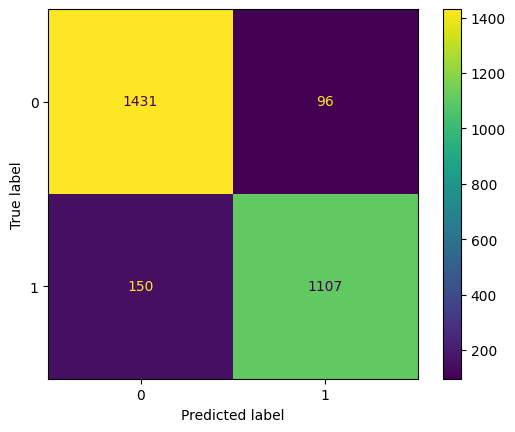

In [36]:
print(classification_report(df_test['FLAG'], y_pred))
cm = confusion_matrix(df_test['FLAG'], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['0', '1'])
disp.plot()
plt.show()

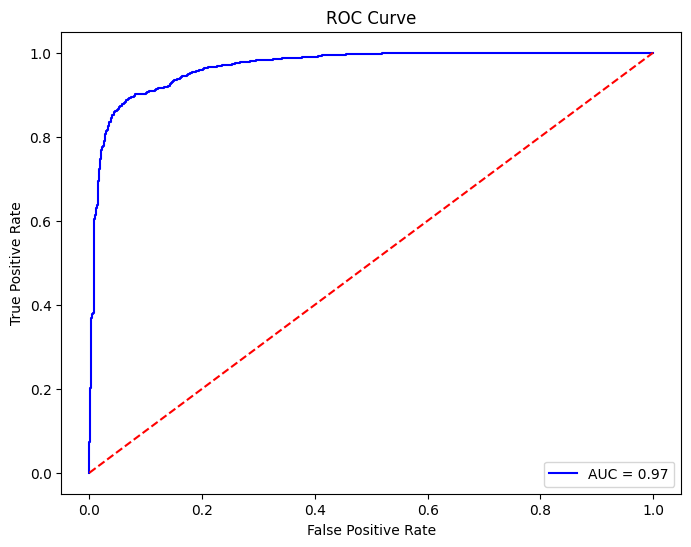

In [37]:
fpr, tpr, threshold = roc_curve(df_test['FLAG'], y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

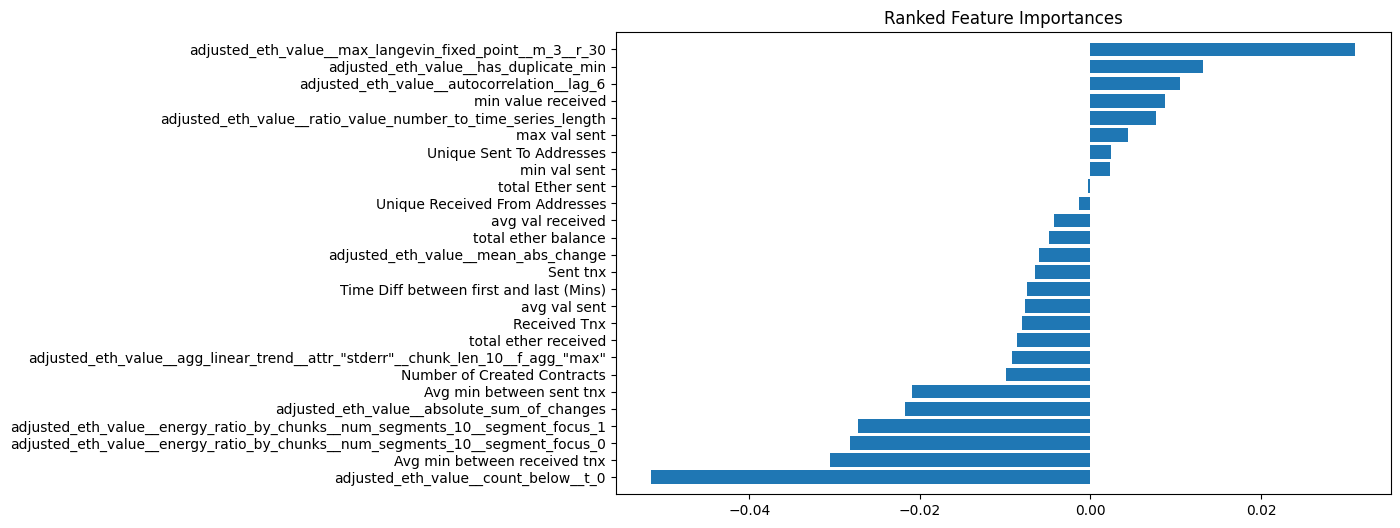

In [42]:
feat_importances = best_model.layers[0].get_weights()[0].mean(axis=1)
indices = np.argsort(feat_importances)

fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Ranked Feature Importances")
plt.barh(range(len(feat_importances)), feat_importances[indices], align="center")
features = ['{}'.format(feature_list[i]) for i in range(len(feature_list))]
plt.yticks(range(len(feat_importances)), [features[idx] for idx in indices])
plt.ylim([-1, len(feat_importances)])
plt.show()